### Open Exploration for the Base Case
# Introduction
This notebook presents our open exploration of the base case, where no policies have been implemented. We assess 10,000 scenarios against this policy by employing Latin Hypercube Sampling (LHS). LHS is advantageous as it keeps track of the previously sampled points, enabling us to achieve a broad coverage across the uncertainty ranges.

Essentially, the following analysis provides insights into the behavior of the IJsseldelta when no actions are taken, as visualized through data. Moreover, we utilize scenario discovery techniques to examine the uncertainties that contribute to the most unfavorable outcomes (Kwakkel, Auping & Pruyt, 2012). Specifically, we employ PRIM and CART for this purpose.

# Imports
The only import thats notably different from the "standard" ones aside from all EMA related ones, is the pickle import to speed data storage up

In [1]:
#load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    Samplers,
)
from ema_workbench.analysis import prim, cart

from problem_formulation import get_model_for_problem_formulation

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

# Open Exploration

First, the model is initialized, using problem formulation 5.

In [3]:
# initiate model
dike_model, planning_steps = get_model_for_problem_formulation(5)

Then, a reference policy is initialized, in which all policy variables are set to 0.

In [4]:
# set reference policy as all 0's
reference = Policy("0_policy", **{l.name: 0 for l in dike_model.levers})

This is the one that we will be using: combining the timesteps into a single value. The model is run, and results are saved

# Model run

In [5]:
# set number of scenarios
n_scenarios = 10_000

# running the model through EMA workbench, using Latin Hypercube Sampling and the reference policy
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=n_scenarios,
                                                          policies=reference,
                                                          uncertainty_sampling=Samplers.LHS)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
100%|████████████████████████████████████| 10000/10000 [21:16<00:00,  7.84it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


as we do not plan on using the timeseries data, we add them up into a single value. This is then saved to a pickle file for later use

In [6]:
df = pd.DataFrame()
for k in outcomes:
    test_list = []
    for i in range(len(experiments)):
        t = outcomes[k][i].sum()
        test_list.append(t)
    df[k]=test_list

with open(r'..\generated_datasets\open_exploration_base_policy.pkl','wb') as pickle_file:
    pickle.dump(df, pickle_file)

The data is then loaded into a dataframe. The cost of death variables are calculated and added to the data.

In [7]:
outcomes = pd.read_pickle(r'..\generated_datasets\open_exploration_base_policy.pkl')

In [8]:
death_cost_per_person = 6_300_000

# calculate the cost of death so every column has the same unit (€)
outcomes["A.1_Deaths_Cost"]=outcomes["A.1_Expected Number of Deaths"]*death_cost_per_person
outcomes["A.2_Deaths_Cost"]=outcomes["A.2_Expected Number of Deaths"]*death_cost_per_person
outcomes["A.3_Deaths_Cost"]=outcomes["A.3_Expected Number of Deaths"]*death_cost_per_person
outcomes["A.4_Deaths_Cost"]=outcomes["A.4_Expected Number of Deaths"]*death_cost_per_person
outcomes["A.5_Deaths_Cost"]=outcomes["A.5_Expected Number of Deaths"]*death_cost_per_person

# drop unnecessary columns
to_drop = ["A.1_Expected Number of Deaths","A.2_Expected Number of Deaths","A.3_Expected Number of Deaths","A.4_Expected Number of Deaths","A.5_Expected Number of Deaths"]
outcomes.drop(to_drop, axis=1, inplace=True)
outcomes['total_cost[€]']= outcomes.sum(axis=1)

In [9]:
#input variables and output combined into a single dataframe
results = experiments.join(outcomes)
results.drop(columns=['policy','model','scenario'], inplace=True)

In [10]:
# save to pickle file
with open(r'..\generated_datasets\open_exploration_base_policy_ALL_scenarios.pkl','wb') as pickle_file:
    pickle.dump(results, pickle_file)

In [3]:
# store pickle file in variable
results = pd.read_pickle(r'..\generated_datasets\open_exploration_base_policy_ALL_scenarios.pkl')

Finding the worst case scenarios top 20, defined by highest total costs

In [4]:
# set number of scenarios
n_scenarios_of_interest = 20

# sort dataframe on total cost, decreasing
results_of_interest = results.sort_values(by='total_cost[€]', ascending=False).head(n_scenarios_of_interest)

# save the worst policies to a pickle file
with open(r'..\generated_datasets\open_exploration_base_policy_worst_scenarios.pkl','wb') as pickle_file:
    pickle.dump(results_of_interest, pickle_file)

# Visualisations

The dikerings are added up together to explore the total costs over all dikerings combined

In [13]:
# make new dataframe with aggregated columns
total_values = pd.DataFrame()
total_values['Expected_Annual_Damage'] = results['A.1_Expected Annual Damage'] + \
                                         results['A.2_Expected Annual Damage'] + \
                                         results['A.3_Expected Annual Damage'] + \
                                         results['A.4_Expected Annual Damage'] + \
                                         results['A.5_Expected Annual Damage']

total_values['Dike_Investment_Costs'] = results['A.1_Dike Investment Costs'] + \
                                        results['A.2_Dike Investment Costs'] + \
                                        results['A.3_Dike Investment Costs'] + \
                                        results['A.4_Dike Investment Costs'] + \
                                        results['A.5_Dike Investment Costs']

total_values['Deaths_Cost'] = results['A.1_Deaths_Cost'] + \
                              results['A.2_Deaths_Cost'] + \
                              results['A.3_Deaths_Cost'] + \
                              results['A.4_Deaths_Cost'] + \
                              results['A.5_Deaths_Cost']

total_values['Expected_Annual_Damage_Overijssel'] = results['A.4_Expected Annual Damage'] + \
                                                    results['A.5_Expected Annual Damage']

total_values['Dike_Investment_Costs_Overijssel'] = results['A.4_Dike Investment Costs'] + \
                                                   results['A.5_Dike Investment Costs']

total_values['Deaths_Cost_Overijssel'] = results['A.4_Deaths_Cost'] + \
                                         results['A.5_Deaths_Cost']

The relevant factors are added up for better representation for our problem owner

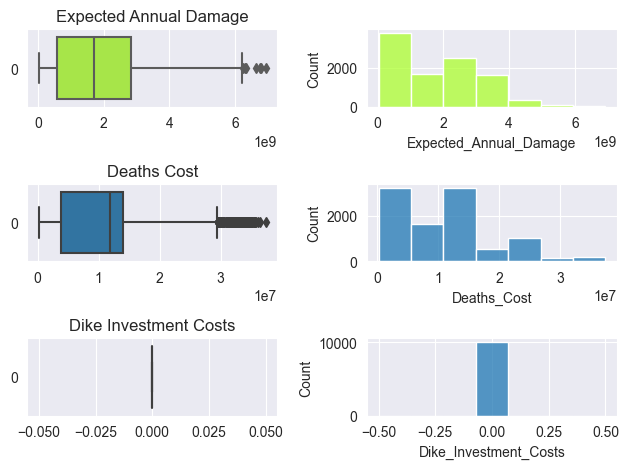

In [14]:
fig, axes = plt.subplots(3,2)

# Expected Annual Damage boxplot
sns.boxplot(
    ax=axes[0,0],
    data=total_values['Expected_Annual_Damage'],
    orient='h',
    color='greenyellow',
).set(title='Expected Annual Damage')

# Deaths_Cost boxplot
sns.boxplot(
    ax=axes[1,0],
    data=total_values['Deaths_Cost'],
    orient='h',
).set(title='Deaths Cost')

# Dike Investment Costs boxplot
sns.boxplot(
    ax=axes[2,0],
    data=total_values['Dike_Investment_Costs'],
    orient='h',
).set(title='Dike Investment Costs')

# Expected Annual Damage histogram
sns.histplot(
    ax=axes[0,1],
    data=total_values['Expected_Annual_Damage'],
    bins=7,
    color='greenyellow',
)

# Dike Investment Costs histogram
sns.histplot(
    ax=axes[2,1],
    data=total_values['Dike_Investment_Costs'],
    bins=7,
)

# Deaths_Cost histogram
sns.histplot(
    ax=axes[1,1],
    data=total_values['Deaths_Cost'],
    bins=7,
)

plt.tight_layout()

The expected annual damage is explored over a large set of scenarios, as are the deaths cost. the dike investment costs are 0 in this situation because the open exploration doesnt include policies, as such no policies also mean no investment costs

## Total cost
The total cost is also represented in both a histogram and boxplot

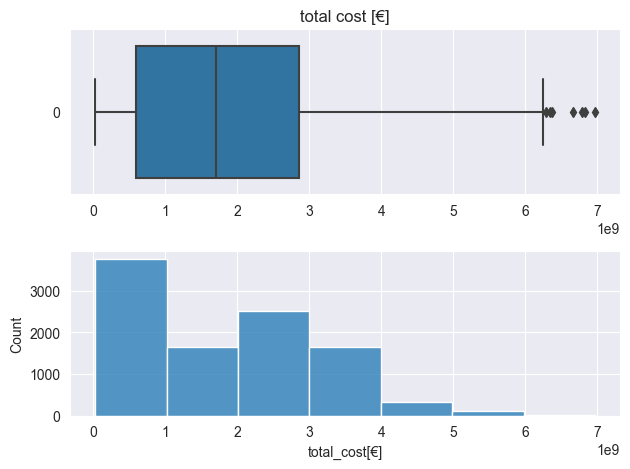

In [15]:
fig, axes = plt.subplots(2)

# make boxplot
sns.boxplot(
    ax=axes[0],
    data=results['total_cost[€]'],
    orient='h',
).set(title='total cost [€]')

# make histplot
sns.histplot(
    ax=axes[1],
    data=results['total_cost[€]'],
    bins=7,
)

# plot plots
plt.tight_layout()

These diagrams show the total cost, in this case the cost of investment, the death costs, and the annual damage cots, for the bade case. ie. when nothing is changed.


### preparations for the visualisations

In [16]:
# Only take the uncertainties
x = results.iloc[:,:19]

# make the variables from the total values dataframe, take 75 percentile and up
y_death_cost = total_values['Deaths_Cost'].values
y_death_cost = y_death_cost > np.percentile(y_death_cost, 75)
y_dama = total_values['Expected_Annual_Damage'].values
y_dama = y_dama > np.percentile(y_dama, 75)
y_invest = total_values['Dike_Investment_Costs'].values
y_invest = y_invest > np.percentile(y_invest, 75)


## Death cost visualisation

[MainProcess/INFO] 10000 points remaining, containing 2500 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.1095, coverage: 0.438, density: 1.0 restricted_dimensions: 3


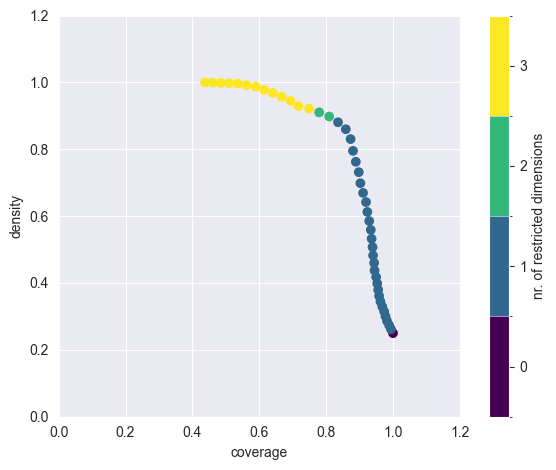

In [17]:
# Perform prim analysis
prim_alg_DC = prim.Prim(x,
                        y_death_cost,
                        threshold=0.75,
                        peel_alpha=0.05,)
box_DC = prim_alg_DC.find_box()

# visualize prim analysis
box_DC.show_tradeoff()
plt.tight_layout()


the density coverage map is plotted for the death costs.

coverage     0.4380
density      1.0000
id          43.0000
mass         0.1095
mean         1.0000
res_dim      3.0000
Name: 43, dtype: float64

             box 43                                 
                min       max      qp value qp value
A.3_pfail  0.000040  0.214871           NaN      0.0
A.1_pfail  0.385394  0.999901  2.205229e-41      NaN
A.2_pfail  0.134155  0.999902  2.464441e-17      NaN



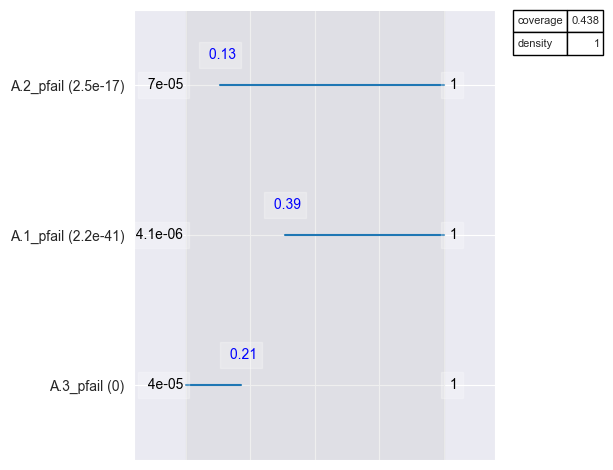

In [18]:
# visualize
box_DC.inspect()
box_DC.inspect(style='graph')
plt.tight_layout()

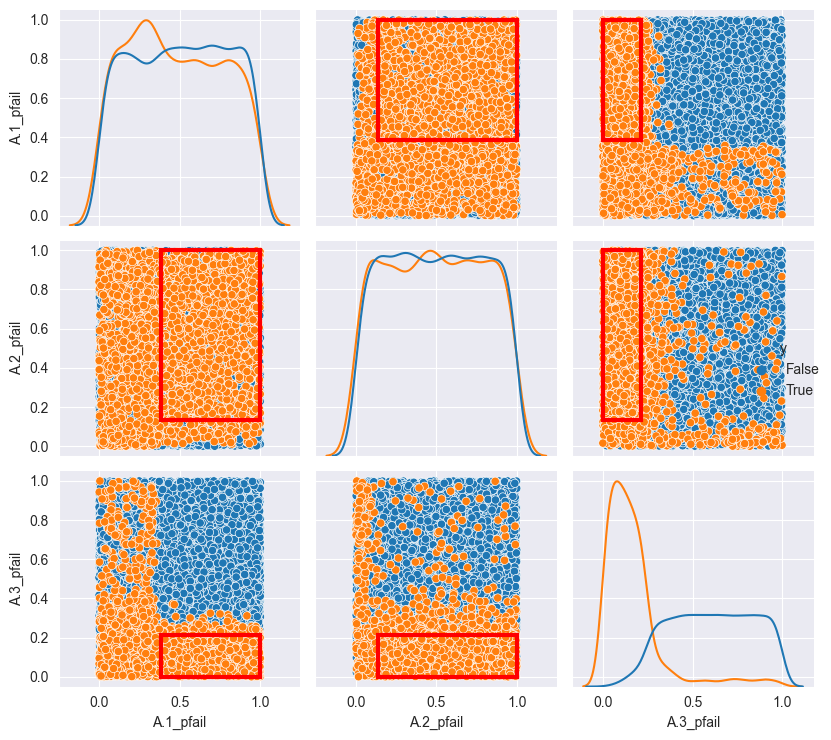

In [19]:
# visualize boxes
box_DC.select(-1)
box_DC.show_pairs_scatter()
fig = plt.gcf()
plt.tight_layout()


## Expected annual damages visualisation

[MainProcess/INFO] 10000 points remaining, containing 2500 cases of interest
[MainProcess/INFO] mean: 0.9982517482517482, mass: 0.0572, coverage: 0.2284, density: 0.9982517482517482 restricted_dimensions: 5


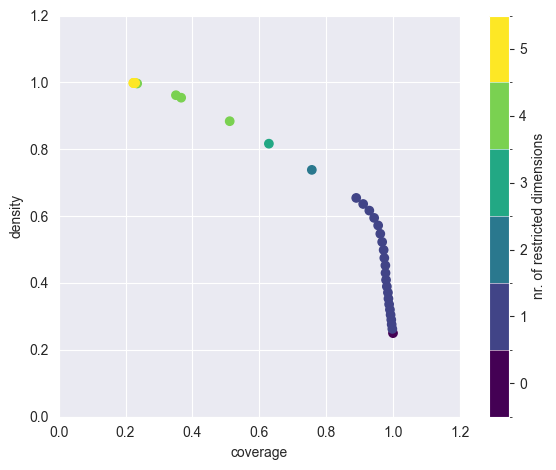

In [20]:
# perform prim analysis
prim_alg_DAM = prim.Prim(x,
                         y_dama,
                         threshold=0.75,
                         peel_alpha=0.05,)
box_DAM = prim_alg_DAM.find_box()

#visualize PRIM
box_DAM.show_tradeoff()
plt.tight_layout()

coverage     0.228400
density      0.998252
id          36.000000
mass         0.057200
mean         0.998252
res_dim      5.000000
Name: 36, dtype: float64

                          box 36                                              
                             min              max      qp value       qp value
A.1_pfail               0.000004         0.321489           NaN  1.795552e-230
A.1_Bmax               30.021873       337.645057           NaN   4.214094e-01
discount rate 1       {1.5, 2.5}       {1.5, 2.5}  3.186746e-26            NaN
discount rate 0       {1.5, 2.5}       {1.5, 2.5}  7.983580e-24            NaN
discount rate 2  {1.5, 2.5, 3.5}  {1.5, 2.5, 3.5}  4.960010e-09            NaN



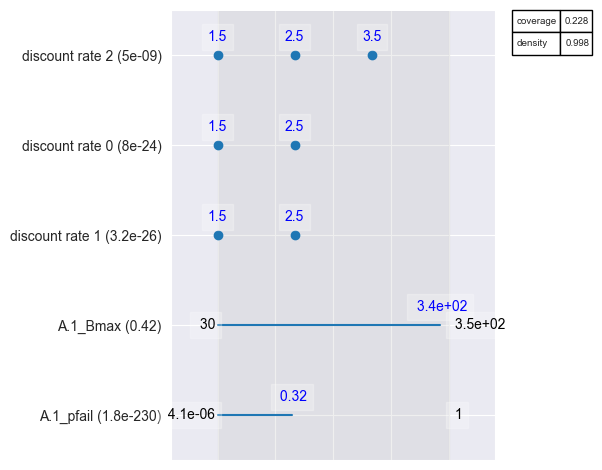

In [21]:
# visualize outcomes
box_DAM.inspect()
box_DAM.inspect(style='graph')
plt.tight_layout()

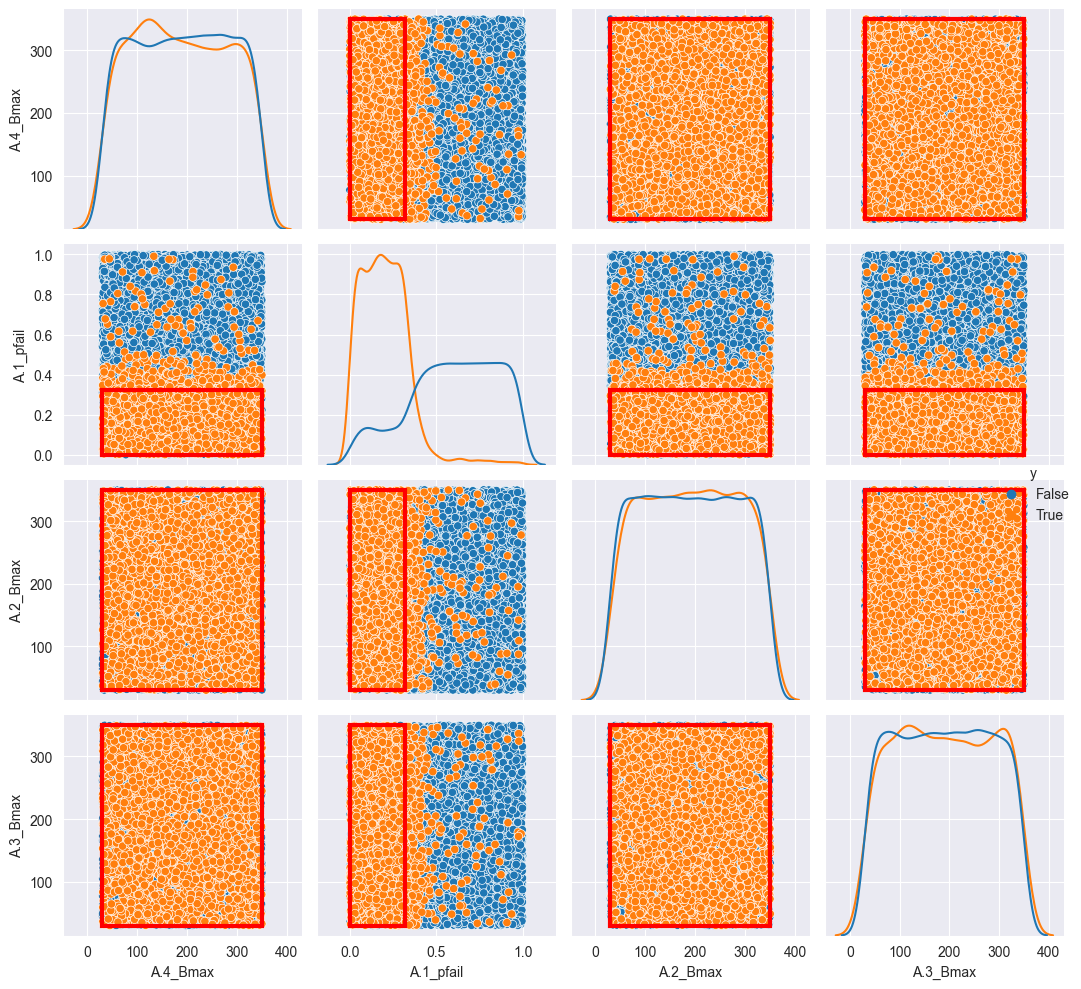

In [22]:
# Visualize boxes
box_DAM.select(-1)
box_DAM.show_pairs_scatter(dims=["A.4_Bmax","A.1_pfail","A.2_Bmax","A.3_Bmax"])
fig_DAM = plt.gcf()
plt.tight_layout()

## Investment costs visualisation
As discussed previously the investment costs are irrelevant for the basecase, but will prove
to be usefull in the future, hence they are included but not used.

In [23]:
# prim_alg_INV = prim.Prim(x,
    #                      y_invest,
    #                      threshold=0.75,
    #                      peel_alpha=0.05,)
# box_INV = prim_alg_INV.find_box()
#
# box_INV.show_tradeoff()
# plt.tight_layout()

In [24]:
# box_INV.inspect()
# box_INV.inspect(style='graph')
# plt.tight_layout()


In [25]:
# box_INV.select(-1)
# box_INV.show_pairs_scatter()
# fig_INV = plt.gcf()
# plt.tight_layout()

# CART charts

### CART chart death cost

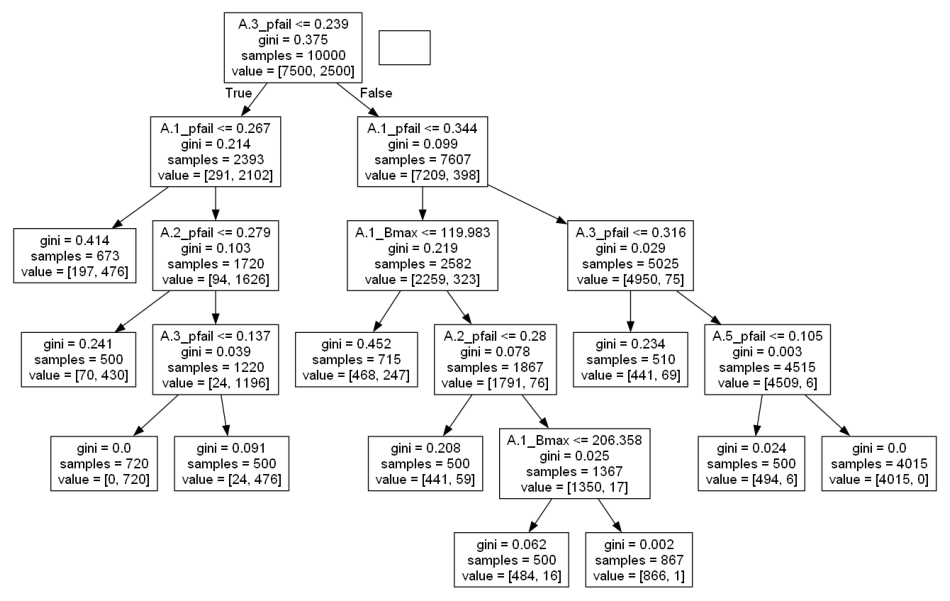

In [26]:
# perform CART analysis
cart_plot = cart.CART(x, y_death_cost, 0.05)
cart_plot.build_tree()

# Make sure to have GraphViz installed (https://www.graphviz.org/download/)
fig = cart_plot.show_tree()
fig.set_size_inches(12, 12)
plt.show()

### CART chart expected annual damages

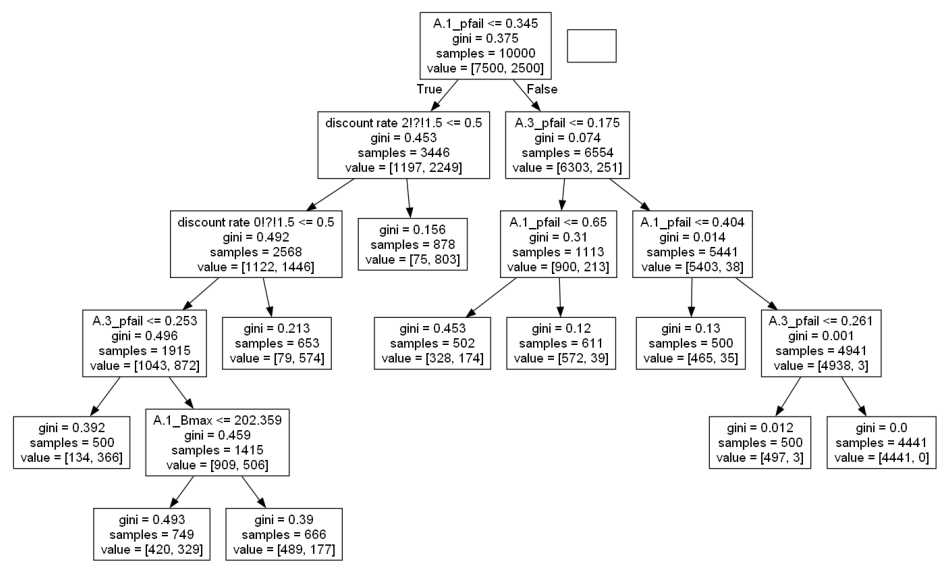

In [27]:
# perform cart analysis
cart_plot = cart.CART(x, y_dama, 0.05)
cart_plot.build_tree()

# Make sure to have GraphViz installed (https://www.graphviz.org/download/)
fig = cart_plot.show_tree()
fig.set_size_inches(12, 12)
plt.show()

### CART chart investment costs
once again, irrelevant at this moment

In [28]:
# plt.show()
# cart_plot = cart.CART(x, y_invest, 0.05)
# cart_plot.build_tree()
#
# # Make sure to have GraphViz installed for the tree to show up (https://www.graphviz.org/download/)
# fig = cart_plot.show_tree()
# fig.set_size_inches(12, 12)
# plt.show()